# Глубокое обучение, ВМК МГУ

## Практическое задание 2. LM на базе GRU

#### Фамилия, имя: Демьянов Иван

Датасет: Large Movie Review Dataset

Тип сети: RNN

## Подключение библиотек, загрузка предобработка данных

### Параметры по умолчанию

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

В качестве данных будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/). Этот датасет содержит отзывы на фильмы. Языковая модел будет обучаться на словарной кодировке.


### Загрузка и предобработка данных

In [2]:
!wget 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar'

--2022-06-02 02:35:21--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar’

aclImdb_v1.tar      100%[===================>]  80.23M  22.2MB/s    in 4.0s    

2022-06-02 02:35:25 (20.0 MB/s) - ‘aclImdb_v1.tar’ saved [84125825/84125825]



In [3]:
import tarfile

aclImdb = tarfile.open(name='aclImdb_v1.tar', mode='r')
aclImdb.extractall()
aclImdb.close()

Выведем пример отзыва на фильм.

In [4]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [5]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

#### Установка и импорт библиотек

In [6]:
!pip3 install torchtext==0.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torchtext
print(torchtext.__version__)

0.12.0


In [8]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Предобработка данных

Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти -- размер словаря, используемого при токенизации. Для задачи языкового моделирования мы можем убрать часть слов (стоп слова, редкие слова), уменьшив тем самым время обучения.

In [9]:
STOPWORDS = nltk.corpus.stopwords.words('english')

In [10]:
import re

def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub('[^a-z ]', '', text).split(' ')
    return [t for t in text if t not in STOPWORDS and t!='']

Теперь создадим словарь, с помощью которого будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab`.

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [11]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [12]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

#### Создание словаря

In [13]:
from collections import Counter

c = Counter()
for i, l in counter.items():
    c[i] = l

new_counter = {}
for i, l in c.most_common(top_n_words):
    new_counter[i] = l

In [14]:
vocab = torchtext.vocab.vocab(new_counter, specials=specials, special_first=True)
vocab.set_default_index(vocab['<unk>'])

In [15]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [16]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 272]

Создание обёртки-датасета для данных с учетом их особенности. 

In [17]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            with open(path) as f:
                text = f.read()
                self.texts.append(text)
                text_tokens = []
                if self.pad_sos:
                    text_tokens.append(self.sos_id)
                for token in tokenize(text)[:self.max_len]:
                    text_tokens.append(vocab.lookup_indices([token])[0])
                if self.pad_eos:
                    text_tokens.append(self.eos_id)
                self.tokens.append(torch.tensor(text_tokens, dtype=torch.long))
                self.ratings.append(int(path.split('_')[-1].split('.')[0]) - 1)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.tensor(dtype=torch.long): rating of the text
                'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.tensor(dtype=torch.long): number of tokens
            }
        """
        # Do not forget to add padding if needed!
        return {
            'text': self.texts[idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.long),
            'tokens': self.tokens[idx],
            'tokens_len': torch.tensor(self.tokens[idx].size(0), dtype=torch.long)
        }
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        return len(self.texts)

In [18]:
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [19]:
test_dataset[0]

{'label': tensor(0),
 'rating': tensor(0),
 'text': "(spoilers) Horrifyingly enough, I have actually SEEN the film that this horrid film was a sequel to. It was called Ator the Fighting Eagle, and I saw it when I was just 8 years old. It made such an awful impression on me that i never forgot it. I've been an MST3K fan for a long time, so when Cavedwellers came out on tape I bought it. I was horrified to realize that it was a sequel to the wretched Ator movie that i'd seen so long ago! Ator's costume has, somehow, gotten ever skimpier than the last time i saw him. How can he wear that tiny little bikini? Doesn't he care that it shows off the fact that he has no...errr...package? And poor Thong...he gets no lines and no girl, and has to follow that frizzy haired girly doofus Ator around all the time. Has anyone else noticed that Miles O'Keefe walks like a woman? No wonder he's not interested in the pretty if somewhat lackluster Meela. The evil but prancy bad guy Zor is more to his taste

#### Создание `DataLoader`

In [20]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    d = batch[0].copy()
    replacements = {'text': 'texts', 'label': 'labels', 'rating': 'ratings',
                    'tokens_len': 'tokens_lens'}
    for i in list(d.keys()):
        if i in replacements.keys():
            d[replacements[i]] = d.pop(i)
    tokens = [d['tokens']]
    for obj in batch[1:]:
        d['texts'] += obj['text']

        d['ratings'] = torch.cat((d['ratings'].reshape(-1), obj['rating'].reshape(-1)))
        d['labels'] = torch.cat((d['labels'].reshape(-1), obj['label'].reshape(-1)))
        d['tokens_lens'] = torch.cat((d['tokens_lens'].reshape(-1), obj['tokens_len'].reshape(-1)))
        tokens.append(obj['tokens'])
    
    d['tokens'] = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=batch_first,
                                                        padding_value=padding_value)
    return d

In [21]:
from functools import partial

new_collate = partial(collate_fn, padding_value=0, batch_first=False)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             collate_fn=new_collate, shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn=new_collate, shuffle=True, num_workers=0)

Посмотрим на какой-нибудь батч:

In [22]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['tokens', 'texts', 'labels', 'ratings', 'tokens_lens']),
 tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
         0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]),
 tensor([0, 2, 0, 3, 6, 9, 6, 8, 8, 0, 9, 9, 0, 0, 0, 0, 1, 3, 8, 1, 2, 0, 6, 9,
         0, 9, 9, 0, 0, 9, 2, 7, 8, 7, 9, 7, 3, 8, 3, 2, 0, 0, 0, 9, 3, 0, 3, 0,
         0, 3, 6, 0, 1, 9, 0, 3, 8, 6, 0, 0, 0, 0, 8, 1]),
 tensor([[ 111,  257, 1486,  ...,  980,    4,    1],
         [  46,  103,    1,  ...,    9, 1328,    1],
         [  52,   36,  107,  ...,   27,  155, 1810],
         ...,
         [1919,    0,    0,  ...,    0,    0,    0],
         [   1,    0,    0,  ...,    0,    0,    0],
         [   1,    0,    0,  ...,    0,    0,    0]]),
 tensor([200,  77,  37,  89,  68,  66,  25, 164, 200, 122,  95,  38,  21,  88,
          58,  73, 200, 200, 200, 119, 138,  17, 200, 160,  69,  77, 159,  7

## Language Modeling с помощью GRU

Для построения языковой модели будем использовать RNN на основе GRU. Это модуль рекуррентной нейронной сети, который является упрощением LSTM. Схема GRU приведена ниже.

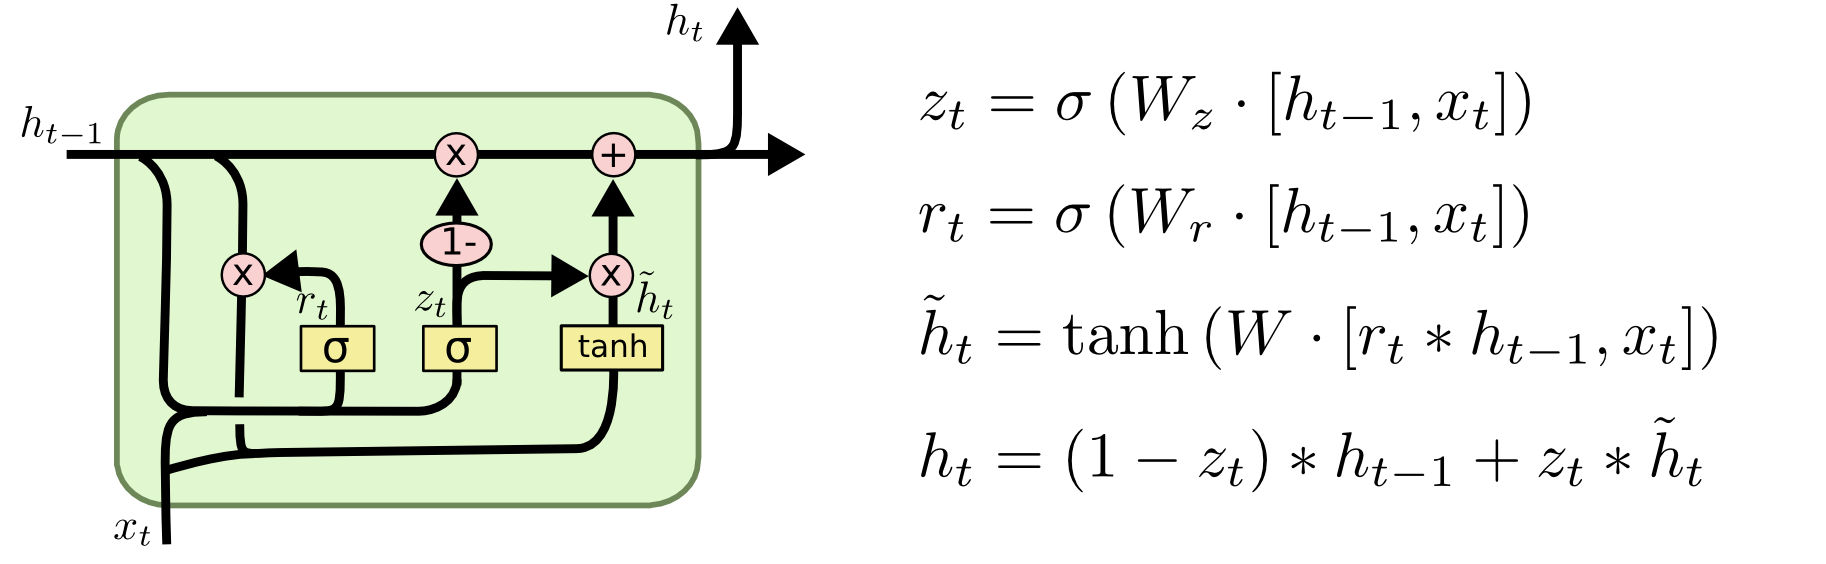

Концептуально языковая модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

В качестве функции потерь будем использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации -- конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

### Реализация модели и цикла обучения

In [23]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


In [24]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.GRU, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        self.word_embeddings = torch.nn.Embedding(len(self.vocab), self.embedding_dim, padding_idx=0)
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
         
        # Create linear layer for classification
        self.output = torch.nn.Linear(self.hidden_dim, self.output_size, bias=False)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        layer1 = self.word_embeddings(tokens) # layer1[max_length, batch_size, embedding_dim]
        
        # Make forward pass through recurrent network
        out, hidden = self.rnn(layer1) # out:[max_length, batch_size, self.hidden_dim]
        # hidden: ([1, batch_size, self.hidden_dim]
        
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        return self.output(out[tokens_lens-1, torch.arange(out.size(1)), :]) #[batch_size, output_size]

In [25]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=torch.nn.GRU, dropout=dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens. Shape: [T, B]
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.tensor: Distribution of next token for each time step. Shape: [T, B, V], V -- size of vocabulary
        """
        # Make embeddings for all tokens
        layer1 = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        out_h, hidden = self.rnn(layer1)
        # Take all hidden states from the last layer of GRU for each step and perform linear transformation
        return self.output(out_h)

Реализуем функцию потерь и оценку качетва для данной задачи.

In [26]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu()-1, 
                                                                 batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu()-1, 
                                                                batch_first=False, enforce_sorted=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        return super().forward(packed_outputs, packed_tokens)

In [27]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch
        :return torch.tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu()-1, 
                                                                 batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:, :], tokens_lens.cpu()-1,
                                                                batch_first=False, enforce_sorted=False).data

        return torch.sum(packed_outputs.argmax(1) == packed_tokens)

Реализуем функции `train_epoch`, `evaluate`, `train` для обучения LM.

In [28]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        optimizer.zero_grad()
        tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens'].to(device)
        predict = model(tokens, tokens_lens)
        loss = loss_fn(predict, tokens, tokens_lens)
        loss.backward()
        optimizer.step()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens'].to(device)
            predict = model(tokens, tokens_lens).to(device)
            
            total_loss += loss_fn(predict, tokens, tokens_lens)
            total_accuracy += accuracy_fn(predict, tokens, tokens_lens)
            total_tokens += torch.sum(tokens_lens - 1)          
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

In [29]:
from collections import Counter

c = Counter()
for i, l in counter.items():
    c[i] = l

new_counter = {}
for i, l in c.most_common(30000):
    new_counter[i] = l

In [30]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
lm_vocab = torchtext.vocab.vocab(new_counter, specials=specials, special_first=True)
lm_vocab.set_default_index(vocab['<unk>'])

In [31]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=40, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=40, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [32]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=1, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=1, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Создадим модель, функцию потерь и оптимизатор: 

In [33]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.1, num_layers=2
).to(device=device)

In [34]:
lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [ ]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 9
)

Epoch: 1/9. Loss (Train/Test): 7.314/7.649. Accuracy (Train/Test): 0.072/0.070
Epoch: 2/9. Loss (Train/Test): 7.081/7.647. Accuracy (Train/Test): 0.070/0.065
Epoch: 3/9. Loss (Train/Test): 6.880/7.679. Accuracy (Train/Test): 0.073/0.066
Epoch: 4/9. Loss (Train/Test): 6.670/7.721. Accuracy (Train/Test): 0.078/0.067
Epoch: 5/9. Loss (Train/Test): 6.500/7.783. Accuracy (Train/Test): 0.082/0.066
Epoch: 6/9. Loss (Train/Test): 6.341/7.855. Accuracy (Train/Test): 0.090/0.066
Epoch: 7/9. Loss (Train/Test): 6.256/7.927. Accuracy (Train/Test): 0.095/0.066
Epoch: 8/9. Loss (Train/Test): 6.762/8.056. Accuracy (Train/Test): 0.069/0.059
Epoch: 9/9. Loss (Train/Test): 6.625/8.074. Accuracy (Train/Test): 0.076/0.060


### Реализация декодера

Теперь, реализуем последнюю деталь -- декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [38]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :return Tuple[torch.tensor, torch.tensor]. Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    embedding = model.word_embeddings(start_tokens)

    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h = []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        output, h = model.rnn(torch.unsqueeze(embedding[time_step], dim=0), h)
        all_h.append(h)

    all_h = torch.stack(all_h, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]

    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)

    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        logits = torch.nn.Softmax(dim=1)(model.output(h[-1]))

        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = 0
            # Sample next_token.
            next_token = torch.multinomial(logits, 1).reshape(-1)
        else:
            # Select most probable token
            next_token = torch.argmax(logits, dim=1).reshape(-1)

        predicted_tokens.append(next_token)

        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Evaluate embedding for next token
        embedding += model.word_embeddings(next_token)

        # Update hidden and cell states
        output, h = model.rnn(embedding, h)

    return torch.stack(predicted_tokens), decoded_lens

## Эксперименты

Попробуем сгенерировать продолжения для нескольких префиксов:

In [40]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=40, top_k=5)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie <unk> movie bad bad one <unk> clawing <unk> <unk> <unk> <unk> <unk> <unk> <unk> cortes overthehill <unk> <unk> cortes <unk> <unk> movie <unk> <unk> <unk> <eos>
<sos> <unk> favorite movie ive ever seen seen seen seen seen seen irreversible since <unk> seen <eos>
<sos> <unk> best movie ever <unk> seen made <unk> <unk> <unk> <unk> movie <unk> <unk> <unk> <unk> <unk> <unk> starewicz <eos>
<sos> <unk> worst movie ive ever seen seen seen seen seen seen avengers movie seen ever seen seen ever seen seen seen seen seen movie <eos>


#### Выберем лучшие параметры для декодирования в целях использования в дальнейших экспериментах.

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie <unk> movie bad bad one <unk> clawing <unk> <unk> <unk> <unk> <unk> <unk> <unk> cortes overthehill <unk> <unk> cortes <unk> <unk> movie <unk> <unk> <unk> <eos>
<sos> <unk> favorite movie ive ever seen seen seen seen seen seen irreversible since <unk> seen <eos>
<sos> <unk> best movie ever <unk> seen made <unk> <unk> <unk> <unk> movie <unk> <unk> <unk> <unk> <unk> <unk> starewicz <eos>
<sos> <unk> worst movie ive ever seen seen seen seen seen seen avengers movie seen ever seen seen ever seen seen seen seen seen movie <eos>


In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> <unk> movie <unk> <unk> cortes la movie got said movie dont would well like overthehill <unk> <unk> shah <unk> starts
<sos> <unk> favorite movie like one dont liked movies know movie ever made say say make ever bother seen know want good movie dont
<sos> <unk> best movie film bad came film <unk> fun ever seen good one see would never see watch laughthe recommend say even <eos>
<sos> <unk> worst movie even one night ever worst made ever heard ever seen madethe worse seen worse never seen seen seen watched ive


In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=100, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> loved movie really bad movie came watch ever movie like quite hysterically expect say much movie movie good hysterically much like quite much movie bad much sucks much one bad thinker good regrettably even well thinker enjoy seen better give see waste enjoy massacred movie <eos>
<sos> <unk> favorite movie sucked plot movie movie <unk> nothing makes like could want fun recommend know see one one worst even movie give one recommend <eos>
<sos> <unk> best movie ive ever ever seen made think seen seen ever seen seen seen seen ever movie worst worst <unk> never movie good seen read movie seen watched got must see francos seen seen ive <unk> massacred seen bin one shunning <eos>
<sos> <unk> worst movie ever ever ever seen watched seen seenthis heard made seen seen good made seen movie better seen <unk> would film seen tripod reiterate seen ishtar <unk> movie <eos>


In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=50, top_k=100)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> first time time say <unk> didnt make say first say film didnt film well know even televised let <eos>
<sos> <unk> favorite movie <unk> directed may pj perfect little <unk> doesnt mcdowall <unk> film like miguel story <unk> well <eos>
<sos> <unk> best movie one doesnt made funniest seen ever read best seen seen since recommend understand say seen even see actors least <unk> movies seen shunning worst watched seen best <eos>
<sos> <unk> worst movie ever ever seen seen ever heard movies seem conceived seen fencing seen movie really movie seen see seen awful would could minutes seen <eos>


In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=10)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie awful good one movie worst really ever one worst worst movie best movies bad one worst bad worst one
<sos> <unk> favorite movie <unk> great ive movie clawing clawing <unk> <unk> <unk> <unk> <unk> <unk> chabrols <unk> movie <unk> cortes chabrols <eos>
<sos> <unk> best movie <unk> <unk> <unk> <unk> <unk> <unk> movie <unk> movie <unk> <unk> <unk> <unk> film <unk> ever <unk> <unk> <unk> <eos>
<sos> <unk> worst movie ever made ever propose seen seen seenthis worst seen made seen avengers seen worst movie movie worst bad <unk> tripod


In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> movie bad <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> favorite movie <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> best movie ever seen seen seen <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> <unk> worst movie ever seen ever seen seen seen seen seen avengers avengers himi avengers worst worst seen movie seen <unk> himi himi


In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> spoilers movie based years seen one movie saw rates film came one movie may starts bin <eos>
<sos> <unk> favorite movie made like worst low fun funny think dont understand kind <unk> cry bad think much like enjoy movie want understand
<sos> <unk> best movie based seen movies like movies adore friday ive seen good never watch im seen historians zatoichi lists friday <eos>
<sos> <unk> worst movie seen ive think seen ever seen seen seen gotten seen worse worst seen bad fencing didnt ever movie say seen


**Итог эксперимента:** как видно, жадное кодирование приводит к повтору слов, что делает предложения менее связанными по смыслу, с увеличением k предложения получаются более связанными. В следующих экспериментах будем использовать такие параметры для декодирования:

* max_generated_len=20

* top_k=50

### Эксперимент №2: размерность скрытого представления

#### В данном эксперименте производем перебор параметра `hidden_size`, фигирирующего в GRU

In [ ]:
import time

lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.1, num_layers=2
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 9
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/9. Loss (Train/Test): 7.654/7.809. Accuracy (Train/Test): 0.071/0.070
Epoch: 2/9. Loss (Train/Test): 7.271/7.630. Accuracy (Train/Test): 0.081/0.077
Epoch: 3/9. Loss (Train/Test): 6.932/7.567. Accuracy (Train/Test): 0.089/0.082
Epoch: 4/9. Loss (Train/Test): 6.636/7.594. Accuracy (Train/Test): 0.095/0.083
Epoch: 5/9. Loss (Train/Test): 6.356/7.664. Accuracy (Train/Test): 0.101/0.082
Epoch: 6/9. Loss (Train/Test): 6.097/7.742. Accuracy (Train/Test): 0.115/0.081
Epoch: 7/9. Loss (Train/Test): 5.883/7.849. Accuracy (Train/Test): 0.126/0.079
Epoch: 8/9. Loss (Train/Test): 5.682/7.955. Accuracy (Train/Test): 0.141/0.079
Epoch: 9/9. Loss (Train/Test): 5.514/8.072. Accuracy (Train/Test): 0.154/0.079
working time is 7m 50s


In [ ]:
import time

lm_model_2 = RNNLM(
    embedding_dim=512, hidden_dim=256, vocab=lm_vocab, dropout=0.1, num_layers=2
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model_2.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses2, lm_train_accuracies2, lm_test_losses2, lm_test_accuracies2 = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model_2, lm_loss_fn, lm_optimizer, device, 9
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/9. Loss (Train/Test): 7.995/8.100. Accuracy (Train/Test): 0.050/0.049
Epoch: 2/9. Loss (Train/Test): 7.882/8.002. Accuracy (Train/Test): 0.058/0.057
Epoch: 3/9. Loss (Train/Test): 7.793/7.938. Accuracy (Train/Test): 0.064/0.061
Epoch: 4/9. Loss (Train/Test): 7.688/7.862. Accuracy (Train/Test): 0.067/0.063
Epoch: 5/9. Loss (Train/Test): 7.630/7.837. Accuracy (Train/Test): 0.068/0.064
Epoch: 6/9. Loss (Train/Test): 7.547/7.799. Accuracy (Train/Test): 0.070/0.066
Epoch: 7/9. Loss (Train/Test): 7.480/7.773. Accuracy (Train/Test): 0.071/0.067
Epoch: 8/9. Loss (Train/Test): 7.429/7.767. Accuracy (Train/Test): 0.074/0.067
Epoch: 9/9. Loss (Train/Test): 7.369/7.758. Accuracy (Train/Test): 0.075/0.068
working time is 5m 37s


In [ ]:
import time

lm_model_3 = RNNLM(
    embedding_dim=512, hidden_dim=1024, vocab=lm_vocab, dropout=0.1, num_layers=2
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model_3.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses3, lm_train_accuracies3, lm_test_losses3, lm_test_accuracies3 = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model_3, lm_loss_fn, lm_optimizer, device, 9
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/9. Loss (Train/Test): 8.555/8.690. Accuracy (Train/Test): 0.047/0.046
Epoch: 2/9. Loss (Train/Test): 8.550/8.702. Accuracy (Train/Test): 0.047/0.046
Epoch: 3/9. Loss (Train/Test): 8.560/8.712. Accuracy (Train/Test): 0.047/0.046
Epoch: 4/9. Loss (Train/Test): 8.516/8.630. Accuracy (Train/Test): 0.048/0.047
Epoch: 5/9. Loss (Train/Test): 8.187/8.355. Accuracy (Train/Test): 0.060/0.059
Epoch: 6/9. Loss (Train/Test): 8.096/8.286. Accuracy (Train/Test): 0.060/0.059
Epoch: 7/9. Loss (Train/Test): 8.082/8.307. Accuracy (Train/Test): 0.061/0.059
Epoch: 8/9. Loss (Train/Test): 8.034/8.284. Accuracy (Train/Test): 0.064/0.062
Epoch: 9/9. Loss (Train/Test): 7.998/8.263. Accuracy (Train/Test): 0.065/0.064
working time is 12m 33s


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

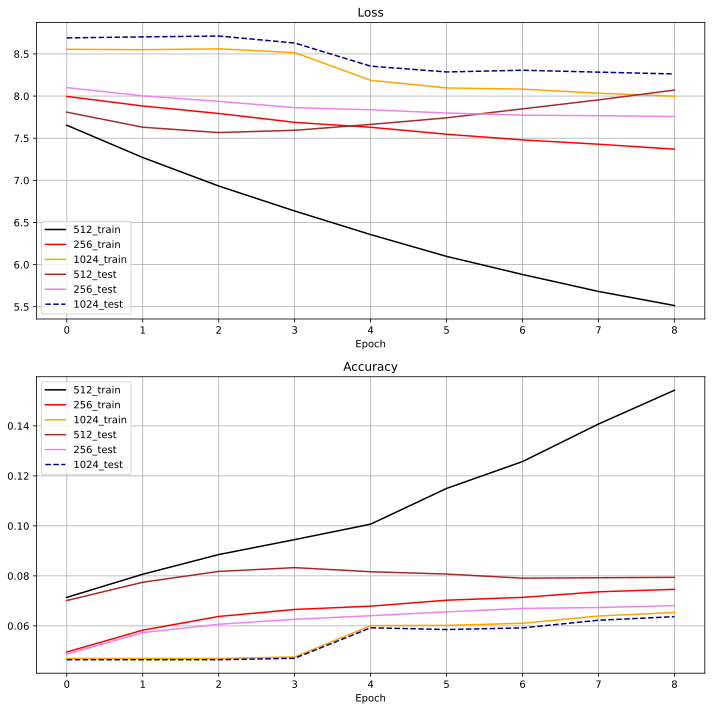

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE

axes[0].grid(True)

axes[0].plot(np.arange(len(lm_train_losses)), [i.item() for i in lm_train_losses],
             label='512_train', linestyle='-', color='black')

axes[0].plot(np.arange(len(lm_train_losses2)), [i.item() for i in lm_train_losses2],
             label='256_train', linestyle='-', color='red')

axes[0].plot(np.arange(len(lm_train_losses3)), [i.item() for i in lm_train_losses3],
             label='1024_train', linestyle='-', color='orange')

axes[0].plot(np.arange(len(lm_test_losses)), [i.item() for i in lm_test_losses],
             label='512_test', linestyle='-', color='brown')

axes[0].plot(np.arange(len(lm_test_losses2)), [i.item() for i in lm_test_losses2],
             label='256_test', linestyle='-', color='violet')

axes[0].plot(np.arange(len(lm_test_losses3)), [i.item() for i in lm_test_losses3],
             label='1024_test', linestyle='--', color='darkblue')

axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].grid(True)

axes[1].plot(np.arange(len(lm_train_accuracies)), [i.item() for i in lm_train_accuracies],
             label='512_train', linestyle='-', color='black')

axes[1].plot(np.arange(len(lm_train_accuracies2)), [i.item() for i in lm_train_accuracies2],
             label='256_train', linestyle='-', color='red')

axes[1].plot(np.arange(len(lm_train_accuracies3)), [i.item() for i in lm_train_accuracies3],
             label='1024_train', linestyle='-', color='orange')

axes[1].plot(np.arange(len(lm_test_accuracies)), [i.item() for i in lm_test_accuracies],
             label='512_test', linestyle='-', color='brown')

axes[1].plot(np.arange(len(lm_test_accuracies2)), [i.item() for i in lm_test_accuracies2],
             label='256_test', linestyle='-', color='violet')

axes[1].plot(np.arange(len(lm_test_accuracies3)), [i.item() for i in lm_test_accuracies3],
             label='1024_test', linestyle='--', color='darkblue')
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> wow film really <unk> terrible awful first great bad like funny made make sucks much think <unk> bad bad dont
<sos> <unk> favorite movie <unk> <unk> movie <unk> years <unk> funny <unk> <unk> shows <unk> films <unk> <unk> really plays well <unk> never great
<sos> <unk> best movie ive ever seen seen seen <unk> long film seen seen <unk> least worse years seen first movie long lot long
<sos> <unk> worst movie seen theater way movie bad minutes thought minutes watching bad much bad movie movie bad thought bad movie movie good


In [ ]:
lm_model_2 = lm_model_2.cpu()
lm_model_2.eval()
decoded_tokens, decoded_lens = decode(lm_model_2, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> know movie didnt see cant dont expect movie really actually seen wasnt seen <unk> made see really go one really
<sos> <unk> favorite movie really bad awful movie story time film got <unk> terrible watch film much <unk> movie better even thought think movie
<sos> <unk> best movie <unk> horror ever one really really bad movie dont make watching <unk> <eos>
<sos> <unk> worst movie made ive seen seen bad bad movie <unk> much one budget good movie ive anything <eos>


In [ ]:
lm_model_3 = lm_model_3.cpu()
lm_model_3.eval()
decoded_tokens, decoded_lens = decode(lm_model_3, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> <unk> horror <unk> many <unk> much job could story ive even funny good say say like really good watch volleyball
<sos> <unk> favorite movie sure <unk> never im im bad good watch characters commented itwhat itwhat itwhat itwhat itwhat itwhat itwhat itwhat itwhat itwhat
<sos> <unk> best movie almost seen movie seen seen like impressed seen movie see seen really celina itwhat itwhat itwhat itwhat itwhat itwhat itwhat
<sos> <unk> worst movie one another <unk> another film movie better read good effects itwhat itwhat itwhat itwhat itwhat itwhat itwhat itwhat itwhat itwhat


**Итог эксперимента:** при размерности скрытого пространства - 256 и 1024 не наблюдается эффекта переобучения. При генерации текста с увеличением размерности скрытого протсранства увеливаются повторения.

### Эксперимент №3: исследование числа слоёв в RNN

На практике использует не более 4х слоев. Проверим работу сетей при различном количестве слоев.

In [ ]:
import time

lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.1, num_layers=3
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 5
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/5. Loss (Train/Test): 7.989/8.086. Accuracy (Train/Test): 0.050/0.049
Epoch: 2/5. Loss (Train/Test): 7.873/8.032. Accuracy (Train/Test): 0.065/0.064
Epoch: 3/5. Loss (Train/Test): 7.779/8.003. Accuracy (Train/Test): 0.069/0.068
Epoch: 4/5. Loss (Train/Test): 7.694/7.975. Accuracy (Train/Test): 0.063/0.061
Epoch: 5/5. Loss (Train/Test): 7.515/7.870. Accuracy (Train/Test): 0.074/0.072
working time is 4m 36s


In [ ]:
import time

lm_model2 = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.1, num_layers=4
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model2.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses2, lm_train_accuracies2, lm_test_losses2, lm_test_accuracies2 = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model2, lm_loss_fn, lm_optimizer, device, 5
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/5. Loss (Train/Test): 8.192/8.316. Accuracy (Train/Test): 0.045/0.044
Epoch: 2/5. Loss (Train/Test): 8.106/8.253. Accuracy (Train/Test): 0.050/0.049
Epoch: 3/5. Loss (Train/Test): 8.062/8.231. Accuracy (Train/Test): 0.049/0.048
Epoch: 4/5. Loss (Train/Test): 8.043/8.216. Accuracy (Train/Test): 0.045/0.043
Epoch: 5/5. Loss (Train/Test): 7.874/8.035. Accuracy (Train/Test): 0.048/0.047
working time is 4m 48s


In [ ]:
import time

lm_model3 = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.1, num_layers=5
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model3.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses3, lm_train_accuracies3, lm_test_losses3, lm_test_accuracies3 = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model3, lm_loss_fn, lm_optimizer, device, 5
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/5. Loss (Train/Test): 8.342/8.454. Accuracy (Train/Test): 0.047/0.046
Epoch: 2/5. Loss (Train/Test): 8.286/8.408. Accuracy (Train/Test): 0.047/0.046
Epoch: 3/5. Loss (Train/Test): 8.214/8.348. Accuracy (Train/Test): 0.048/0.047
Epoch: 4/5. Loss (Train/Test): 8.182/8.312. Accuracy (Train/Test): 0.047/0.046
Epoch: 5/5. Loss (Train/Test): 8.153/8.287. Accuracy (Train/Test): 0.047/0.046
working time is 5m 6s


In [35]:
import time

lm_model3 = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.1, num_layers=5
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction='sum')
lm_optimizer = torch.optim.Adam(lm_model3.parameters(), lr=0.005, weight_decay=1.2e-6)

t_start = time.perf_counter()

lm_train_losses3, lm_train_accuracies3, lm_test_losses3, lm_test_accuracies3 = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model3, lm_loss_fn, lm_optimizer, device, 5
)

all_time = time.perf_counter() - t_start
print(f'working time is {all_time//60:.0f}m {all_time%60:.0f}s')

Epoch: 1/5. Loss (Train/Test): 8.082/8.185. Accuracy (Train/Test): 0.047/0.046
Epoch: 2/5. Loss (Train/Test): 8.054/8.158. Accuracy (Train/Test): 0.047/0.046
Epoch: 3/5. Loss (Train/Test): 8.029/8.144. Accuracy (Train/Test): 0.047/0.046
Epoch: 4/5. Loss (Train/Test): 8.041/8.160. Accuracy (Train/Test): 0.047/0.046
Epoch: 5/5. Loss (Train/Test): 8.026/8.142. Accuracy (Train/Test): 0.047/0.046
working time is 5m 10s


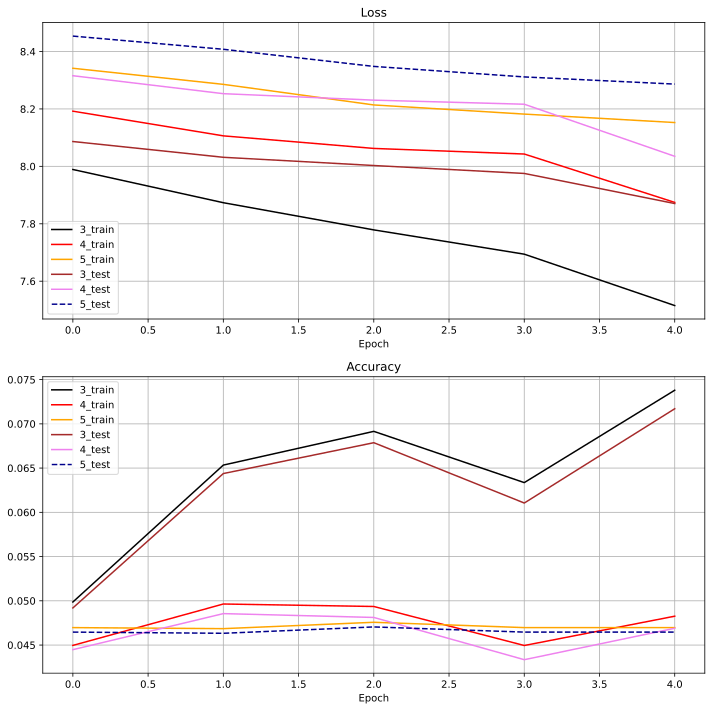

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE

axes[0].grid(True)

axes[0].plot(np.arange(len(lm_train_losses)), [i.item() for i in lm_train_losses],
             label='3_train', linestyle='-', color='black')

axes[0].plot(np.arange(len(lm_train_losses2)), [i.item() for i in lm_train_losses2],
             label='4_train', linestyle='-', color='red')

axes[0].plot(np.arange(len(lm_train_losses3)), [i.item() for i in lm_train_losses3],
             label='5_train', linestyle='-', color='orange')

axes[0].plot(np.arange(len(lm_test_losses)), [i.item() for i in lm_test_losses],
             label='3_test', linestyle='-', color='brown')

axes[0].plot(np.arange(len(lm_test_losses2)), [i.item() for i in lm_test_losses2],
             label='4_test', linestyle='-', color='violet')

axes[0].plot(np.arange(len(lm_test_losses3)), [i.item() for i in lm_test_losses3],
             label='5_test', linestyle='--', color='darkblue')

axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

axes[1].grid(True)

axes[1].plot(np.arange(len(lm_train_accuracies)), [i.item() for i in lm_train_accuracies],
             label='3_train', linestyle='-', color='black')

axes[1].plot(np.arange(len(lm_train_accuracies2)), [i.item() for i in lm_train_accuracies2],
             label='4_train', linestyle='-', color='red')

axes[1].plot(np.arange(len(lm_train_accuracies3)), [i.item() for i in lm_train_accuracies3],
             label='5_train', linestyle='-', color='orange')

axes[1].plot(np.arange(len(lm_test_accuracies)), [i.item() for i in lm_test_accuracies],
             label='3_test', linestyle='-', color='brown')

axes[1].plot(np.arange(len(lm_test_accuracies2)), [i.item() for i in lm_test_accuracies2],
             label='4_test', linestyle='-', color='violet')

axes[1].plot(np.arange(len(lm_test_accuracies3)), [i.item() for i in lm_test_accuracies3],
             label='5_test', linestyle='--', color='darkblue')
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Как видно по графикам, использовать многослойные RNN - не самая лучшая идея;)

In [ ]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> saw movie could seen film know one ever <eos>
<sos> <unk> favorite movie made many predictable people made story first would liked give thats make <eos>
<sos> <unk> best movie <unk> watching people favorite first movie movie <unk> dont movie seen time like movie time watching time movie get <eos>
<sos> <unk> worst movie give see im effects ever give movie <eos>


In [ ]:
lm_model2 = lm_model2.cpu()
lm_model2.eval()
decoded_tokens, decoded_lens = decode(lm_model2, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> see know film saw read good like know bad years <unk> like get watching like still ive im saw really
<sos> <unk> favorite movie many watching <unk> film movie watched good one great made got <eos>
<sos> <unk> best movie first want good years first watch better movies say better good <unk> movie movies say <unk> first like movie really
<sos> <unk> worst movie worst bad lot much ive see <unk> even bad still see good movie movie one say great bad film ever


In [41]:
lm_model3 = lm_model3.cpu()
lm_model3.eval()
decoded_tokens, decoded_lens = decode(lm_model3, start_tokens, start_tokens_lens, max_generated_len=20, top_k=50)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> say acting people know film would <unk> <eos>
<sos> <unk> favorite movie <unk> story also film <unk> <unk> didnt people <unk> <unk> watch <unk> <unk> good <unk> love plot thing would seen
<sos> <unk> best movie acting movie actually film film <eos>
<sos> <unk> worst movie old good didnt know really plot <unk> time one <unk> <eos>


Увеличение слоев не способствовало увеличению качества текста.

**Выводы:** в данной работе была рассмотрена языковая модель на основе GRU с последующим перебором параметров.